In [1]:
# 1. Import thư viện
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import GRU, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/Users/nguyensithi/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#2 Read and preprocess data
df = pd.read_csv("BID_Stock_Data.csv")
#df = pd.read_csv('AAPL.csv', header=0, parse_dates=[0], index_col=0)
df = df[['Close']].dropna().reset_index(drop=True)

In [3]:
# 4. Chia train test
train_size = int(0.9 * len(df))
test_size = len(df) - train_size
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

In [4]:
# 5. Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [5]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   # i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
look_back = 1
X_train, Y_train = create_dataset(scaled_data[:train_size], look_back)
X_test, Y_test = create_dataset(scaled_data[train_size:], look_back)

In [6]:
# 6. Reshape input to be [samples, time steps, features]
X_train_gru = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_gru = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [7]:
# 7. Lasso model
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, Y_train)

Lasso(alpha=0.01)

In [8]:
# 8. Define GRU model
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(1, look_back)))
gru_model.add(GRU(units=50))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(X_train_gru, Y_train, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
2216/2216 - 3s - loss: 0.0023 - 3s/epoch - 1ms/step
Epoch 2/100
2216/2216 - 2s - loss: 4.7602e-04 - 2s/epoch - 887us/step
Epoch 3/100
2216/2216 - 2s - loss: 4.8032e-04 - 2s/epoch - 895us/step
Epoch 4/100
2216/2216 - 2s - loss: 4.7820e-04 - 2s/epoch - 872us/step
Epoch 5/100
2216/2216 - 2s - loss: 4.5782e-04 - 2s/epoch - 903us/step
Epoch 6/100
2216/2216 - 2s - loss: 4.2451e-04 - 2s/epoch - 874us/step
Epoch 7/100
2216/2216 - 2s - loss: 4.3816e-04 - 2s/epoch - 873us/step
Epoch 8/100
2216/2216 - 2s - loss: 4.0213e-04 - 2s/epoch - 876us/step
Epoch 9/100
2216/2216 - 2s - loss: 4.1676e-04 - 2s/epoch - 875us/step
Epoch 10/100
2216/2216 - 2s - loss: 3.8638e-04 - 2s/epoch - 877us/step
Epoch 11/100
2216/2216 - 2s - loss: 4.0789e-04 - 2s/epoch - 900us/step
Epoch 12/100
2216/2216 - 2s - loss: 3.9028e-04 - 2s/epoch - 909us/step
Epoch 13/100
2216/2216 - 2s - loss: 3.9254e-04 - 2s/epoch - 880us/step
Epoch 14/100
2216/2216 - 2s - loss: 3.8657e-04 - 2s/epoch - 876us/step
Epoch 15/100
2216/221

In [10]:
# 9. Combine LSR and GRU
X_meta_train = np.column_stack((lasso.predict(X_train), gru_model.predict(X_train_gru).flatten()))
X_meta_test = np.column_stack((lasso.predict(X_test), gru_model.predict(X_test_gru).flatten()))

8/8 [==============================] - 0s 876us/step


In [11]:
# 10.Train meta-learner
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()
meta_model.fit(X_meta_train, Y_train)

# Utilize meta-learner to predict
ensemble_pred = meta_model.predict(X_meta_test)
ensemble_pred = scaler.inverse_transform(ensemble_pred.reshape(-1, 1))

In [12]:
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error
# 11. Đánh giá độ chính xác test
#RMSE
test_rmse = np.sqrt(np.mean((ensemble_pred - Y_test)**2))
print('Testing RMSE:', test_rmse)
#MSLE
test_msle = np.mean((np.log1p(Y_test) - np.log1p(ensemble_pred))**2)
print('Testing MSLE:', test_msle)
# Mean Absolute Percentage Error (MAPE)
test_mape = 100 * np.mean(np.abs((Y_test - ensemble_pred) / Y_test))
print('Testing MAPE:', test_mape)

Testing RMSE: 39300.52311097145
Testing MSLE: 98.91181396230982
Testing MAPE: 4472168.737245763


In [13]:
future_steps = 30  

# 12. Predict next 30 days
ensemble_future_pred = []
last_window = scaled_data[-look_back:]  # Cập nhật last_window cho bước thời gian cuối cùng của dữ liệu

for i in range(future_steps):
    # Chuẩn bị dữ liệu cho mỗi bước thời gian trong tương lai
    last_window_gru = np.reshape(last_window, (1, 1, look_back))
    lasso_future_pred = lasso.predict(last_window)
    gru_future_pred = gru_model.predict(last_window_gru).flatten()
    X_meta_future = np.column_stack((lasso_future_pred, gru_future_pred))

    # Dự đoán sử dụng meta-learner
    future_pred = meta_model.predict(X_meta_future)
    ensemble_future_pred.append(future_pred[0])

    # Cập nhật last_window cho bước tiếp theo
    last_window = np.append(last_window[1:], future_pred)[np.newaxis]

ensemble_future_pred = scaler.inverse_transform(np.array(ensemble_future_pred).reshape(-1, 1))


1/1 [==============================] - 0s 11ms/step


In [14]:
# 13. Adjusting index for plotting
last_index = df.index[-1]
future_index = range(last_index + 1, last_index + future_steps + 1)

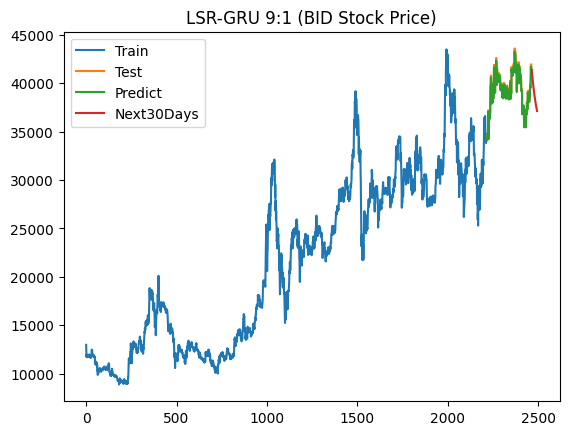

In [15]:
# 14. Vẽ đồ thị
plt.plot(df.index[:train_size], scaler.inverse_transform(scaled_data[:train_size]), label='Train')
plt.plot(df.index[train_size:train_size+len(Y_test)], scaler.inverse_transform(scaled_data[train_size:train_size+len(Y_test)]), label='Test')
plt.plot(df.index[train_size:train_size+len(ensemble_pred)], ensemble_pred, label='Predict')
plt.plot(future_index, ensemble_future_pred, label='Next30Days')
plt.title('LSR-GRU 9:1 (BID Stock Price)')
plt.legend()
plt.show()